## HWW5:

В домашньому завданні до даного модулю ви потренуєтесь робити тестове завдання для влаштування на роботу. 
За даними акселерометра з мобільного телефону потрібно класифікувати, якою діяльністю займається людина: йде, стоїть, біжить чи йде по сходах. 
Знайти датасет ви можете за посиланням....

Використайте алгоритми SVM та випадковий ліс з бібліотеки scikit-learn. Як характеристики можете брати показники з акселерометра, проте щоб покращити результати роботи алгоритмів, спочатку можна підготувати наш датасет і розрахувати часові ознаки (time domain features). Більше ці характеристики описані в даній статті.

Порівняйте результати роботи обох алгоритмів на різних фічах та різні моделі між собою.

In [190]:
import math as m
from pathlib import Path
import pickle
from typing import Union

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline

## Data preparation:

In [191]:
def read_from_csvfile(file: Path) -> pd.DataFrame:
    """Read content from csv-file and return dataframe from content."""
    df = pd.read_csv(file)
    
    return df

In [192]:
df = pd.DataFrame()
classification_human_activity = {}

- https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/
- https://pandas.pydata.org/docs/reference/api/pandas.concat.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.skew.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.kurt.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.var.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmin.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html
- https://stackoverflow.com/questions/53177327/how-to-compute-shannon-entropy-of-information-from-a-pandas-dataframe
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

In [193]:
def get_statistical_features(y: str, df: pd.DataFrame) -> pd.DataFrame:
    # y - type real data; df - sample data. 
    if y not in classification_human_activity:
        classification_human_activity[y] = len(classification_human_activity)

    data = {
            'activity': [classification_human_activity[y]],
            # 'max_x': [max(df['accelerometer_X'])],  # [df['accelerometer_X'].describe().loc['max']],
            # 'min_x': [min(df['accelerometer_X'])],  # [df['accelerometer_X'].describe().loc['min']],
            # 'mean_x': [df['accelerometer_X'].mean(axis=0)],  # [df['accelerometer_X'].describe().loc['mean']],
            # 'med_x': [df['accelerometer_X'].median(axis=0)],  # median
            # 'std_x': [df['accelerometer_X'].std(axis=0)],  # Standard deviation !!= [df['accelerometer_Y'].describe().loc['std']], 
            # 'skew_x': [df['accelerometer_X'].skew(axis=0)],  # skewness
            # 'kurt_x': [df['accelerometer_X'].skew(axis=0)],  # kurtosis
            # 'var_x': [df['accelerometer_X'].var(axis=0)],  # variance
            # 'idxmax_x': [df['accelerometer_X'].idxmax(axis=0)],  # index of first occurrence of maximum over requested axis
            # 'idxmin_x': [df['accelerometer_X'].idxmin(axis=0)],  # index of first occurrence of minimum over requested axis
            }
    [data.update({
                  f'max_{col[-1]}':[max(df[col])],
                  f'min_{col[-1]}':[min(df[col])],
                  f'mean_{col[-1]}':[df[col].mean(axis=0)],
                  f'med_{col[-1]}':[df[col].median(axis=0)],  # median
                  f'std_{col[-1]}':[df[col].std(axis=0)],  # Standard deviation
                  f'skew_{col[-1]}':[df[col].skew(axis=0)],  # skewness
                  f'kurt_{col[-1]}':[df[col].kurt(axis=0)],  # kurtosis
                  f'var_{col[-1]}':[df[col].var(axis=0)],  # variance
                  f'idxmax_{col[-1]}':[df[col].idxmax(axis=0)],  # index of first occurrence of maximum over requested axis
                  f'idxmin_{col[-1]}':[df[col].idxmin(axis=0)],  # index of first occurrence of minimum over requested axis
                #   f'rmse_{col[-1]}':[mean_squared_error(df[col], np.array([df[col].mean(axis=0) for _ in range(df.shape[0])]), squared=False)],  # Root Mean Square Error
                #   f'mae_{col[-1]}':[mean_absolute_error(df[col], np.array([df[col].mean(axis=0) for _ in range(df.shape[0])]))],  # mean absolute error
                  }) 
        for col in df.columns]

    [data.update({
                  f'rmse_{col[-1]}':[mean_squared_error(df[col], [data[f'mean_{col[-1]}'] for __ in range(df.shape[0])], squared=False)],  # variance# Root Mean Square Error
                  f'mae_{col[-1]}':[mean_absolute_error(df[col], [data[f'mean_{col[-1]}'] for __ in range(df.shape[0])])],  # mean absolute error
                  }) 
        for col in df.columns]
    df_f = pd.DataFrame(data)
    
    return df_f

In [194]:
def get_data_to_dafaframe(path: Union[str, Path], df: pd.DataFrame) -> pd.DataFrame:
    path = Path(path)
    if not path.is_dir() or not path.exists():
        return None
    
    for file_system_object in path.iterdir():
        if file_system_object.is_dir():
            df = get_data_to_dafaframe(file_system_object, df)
            
        elif file_system_object.suffix.lower() in ('.csv',):
            df_add = read_from_csvfile(file_system_object)
            df = pd.concat([df, get_statistical_features(file_system_object.stem.split('-')[0], df_add)], ignore_index=True)

    return df

In [195]:
def save_prepared_data(df: pd.DataFrame, file_name: str='data1.bin') -> None:
    with open(file_name, 'wb') as fh:
        pickle.dump(df, fh)


In [196]:
def load_prepared_data(file_name: str='data1.bin') -> pd.DataFrame:
    with open(file_name, 'rb') as fh:
        df = pickle.load(fh)

    return df

Якщо немає підготовлених даних (data0.bin & data1.bin) - обробляємо знову з сирих

In [197]:
if Path('data0.bin').is_file() and Path('data1.bin').is_file():
    df = load_prepared_data()
    classification_human_activity = load_prepared_data('data0.bin')

else:
    df = get_data_to_dafaframe('data', df)
    save_prepared_data(df)
    save_prepared_data(classification_human_activity, 'data0.bin')

In [198]:
df.tail(6)

,activity,max_X,min_X,mean_X,med_X,std_X,skew_X,kurt_X,var_X,idxmax_X,...,kurt_Z,var_Z,idxmax_Z,idxmin_Z,rmse_X,mae_X,rmse_Y,mae_Y,rmse_Z,mae_Z
6456,3,1.024718,-10.036493,-3.997519,-3.380613,3.011451,-0.338673,-0.557672,9.068838,5,...,0.374707,6.062126,26,21,2.960835,2.408620,4.719099,3.860922,2.420755,1.881598
6457,3,8.398860,-6.224924,0.826638,1.244985,2.653484,-0.012359,2.275576,7.040978,8,...,9.031841,30.027026,7,11,2.608884,1.942251,3.153400,2.494843,5.387590,3.226745
6458,3,12.196063,-6.354211,2.587334,2.506730,3.311198,-0.104480,3.238238,10.964034,16,...,4.507524,10.078007,28,16,3.255544,2.209689,5.150007,4.039338,3.121230,1.975557
6459,3,8.073248,-4.582502,2.830745,3.447650,3.302172,-0.492919,-0.453013,10.904337,11,...,3.758635,20.366468,27,29,3.246669,2.650009,4.630977,3.314692,4.437069,2.838800
6460,3,9.035717,-6.904877,-0.025219,-0.399831,3.414785,0.284005,0.775833,11.660759,1,...,2.128289,19.916885,1,29,3.357390,2.592356,5.177956,3.986420,4.387823,2.956030
6461,3,8.398860,-6.224924,0.964544,1.376666,2.958615,-0.059084,0.721621,8.753403,20,...,4.863290,39.297190,19,23,2.908887,2.250614,4.252132,3.073357,6.163382,4.058800


Розшифровка позначень типів діяльності

In [284]:
classification_human_activity

{0: 'walking', 1: 'running', 2: 'idle', 3: 'stairs'}

In [285]:
if not classification_human_activity.get(0):
    classification_human_activity = {val:key for key, val in classification_human_activity.items()}

classification_human_activity

{0: 'walking', 1: 'running', 2: 'idle', 3: 'stairs'}

X = df.iloc[:, 1:]
y = df.iloc[:, 0]

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

(рандомне перемішування даних shuffle=True може суттєво впливати на результати співставлення різних алгоритмів, усереднено - орієнтовно достатня точність)

In [286]:
from sklearn.model_selection import train_test_split

# Робимо вибірки - розділяємо всі дані на групи для тренування, валідаційну та тестову
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)  # random_state=42
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((4329, 36), (1066, 36), (1067, 36), (4329,), (1066,), (1067,))

In [287]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
# Тренуємо моделі (ймовірність - probability)
# C = 100.  # коефіцієнт ваги функції втрат (як вірогіднісний), <1 менша точність, щоб алгоритм більше орієнтувався на margin ; більший - більша точність, але!
# svc_linear = SVC(kernel='linear', C=C, probability=True).fit(X_train, y_train)  # kernel - ядрова функція для викривлення простору даних, щоб побудувати простішу гіперплощину - простішу лінійну модель
# svc_rbf = SVC(kernel='rbf', C=C, gamma=0.7, probability=True).fit(X_train, y_train)
# svc_poly = SVC(kernel='poly', degree=3, C=C, probability=True).fit(X_train, y_train)
# # for clf in (svc_linear, svc_rbf, svc_poly):
# #     h = clf.predict()

Натренуємо модельки (ймовірність - probability)

In [294]:
C = [10**q for q in range(-3, 4)]  # 7
gamma = [10**g for g in range(-2, 2)]  # 4+
gamma.append('auto')
degree = [d for d in range(2,7)]  # 6
models_svc_linear = {f'linear>C={coef_C}':SVC(kernel='linear', C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C}
models_svc_rbf = {f'rbf>C={coef_C};g={coef_g}': SVC(kernel='rbf', C=coef_C, gamma=coef_g, probability=True).fit(X_train, y_train) for coef_C in C for coef_g in gamma}
models_svc_poly = {f'poly>C={coef_C};d={deg}': SVC(kernel='poly', degree=deg, C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C for deg in degree}

- https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972

In [290]:
# отримаємо значення моделей за валідаційними вибірками і перевіримо узагальнену точність [accuracy_score, f1_score, ]
def run_model(model: SVC, new_data: pd.DataFrame, real_result: pd.Series) -> list:
    y_valid_pred = model.predict_proba(new_data)  # [:, 2]  # probability for classification_human_activity[2]
    from_model_by_max = pd.DataFrame(y_valid_pred).idxmax(1).values
    m1 = accuracy_score(real_result, from_model_by_max)
    m2 = f1_score(real_result, from_model_by_max, average='weighted')  # None = for each class
    # roc_auc_score(real_result, y_valid_pred)  #! multi_class must be in ('ovo', 'ovr')
    
    return [m1, m2]

In [295]:
# обрахуємо результати перевірки
valid_linear = {mark:run_model(model, X_valid, y_valid) for mark, model in models_svc_linear.items()}
valid_rbf = {mark:run_model(model, X_valid, y_valid) for mark, model in models_svc_rbf.items()}
valid_poly = {mark:run_model(model, X_valid, y_valid) for mark, model in models_svc_poly.items()}

In [296]:
# порівняємо результати між собою...
valid_results = {}
valid_results.update(valid_linear)
valid_results.update(valid_rbf)
valid_results.update(valid_poly)
valid_results = pd.DataFrame(valid_results).T


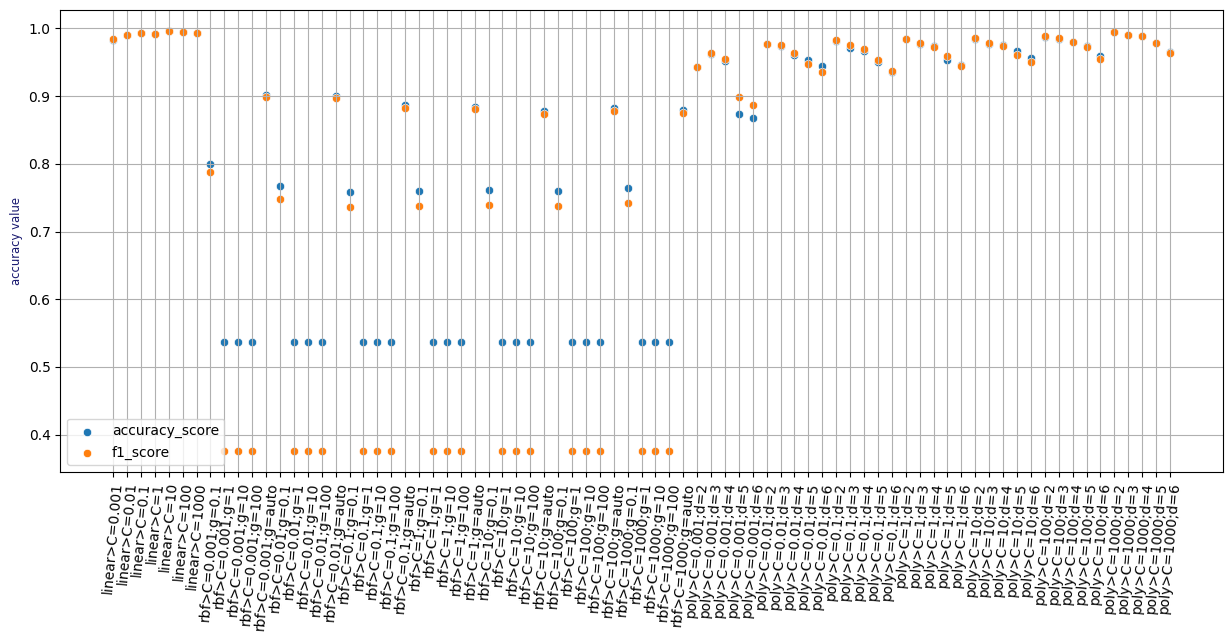

In [297]:
plt.figure(figsize=(15,6))
ax = sns.scatterplot(x=valid_results.index, y=0, data=valid_results, label='accuracy_score')
ax = sns.scatterplot(x=valid_results.index, y=1, data=valid_results, label='f1_score')
plt.xticks(rotation=85)
plt.ylabel('accuracy value', fontsize='small', color='midnightblue')
plt.grid()
ax.legend()
plt.show()


In [234]:
svc_linear = SVC(kernel='linear', C=100, probability=True).fit(X_train, y_train)
y_valid_pred = svc_linear.predict_proba(X_valid)  # y_valid_pred = svc_linear.predict(X_valid)[:, 1]

In [243]:
y_valid_pred

array([[2.17163776e-03, 6.22958173e-03, 9.89493692e-01, 2.10508887e-03],
       [4.65922877e-07, 9.99631347e-01, 3.79296813e-05, 3.30257389e-04],
       [3.06435631e-04, 2.04061665e-03, 9.97239572e-01, 4.13376187e-04],
       ...,
       [1.23574492e-02, 9.81865711e-01, 1.48658438e-03, 4.29025553e-03],
       [1.80789258e-07, 9.99953296e-01, 1.42759905e-06, 4.50955977e-05],
       [1.47083531e-08, 9.99968067e-01, 1.02103567e-05, 2.17078956e-05]])

In [255]:
roc_auc_score(y_valid, pd.DataFrame(y_valid_pred).idxmax(1).values)  # y_valid_pred

ValueError: multi_class must be in ('ovo', 'ovr')